*This notebook is an artifact from the [Biomedical Translator Project](https://ncats.nih.gov/translator/about) hackathon hosted by NIH NCATS on May 9-11th, 2017 (followed by minimal post-hackathon activities through May 25th, 2017)*

### Clinical query workflow question: Are there differences in environmental exposure among patients with early-onset vs late-onset disease?

**Contributors**
* Kenneth Roe, Richard Zhu, Casey Overby (Hopkins)
* Rajarshi Guha (NCATS)
* Chunhua Weng, Chi Yuan (Columbia)
* James Champion (UNC)
* Marcin von Grotthuss, Oliver Ruebanacker (Broad)

**Overview of steps**
* Find patients diagnosed with Asthma
* Find age of diagnosis for Asthma patients
* Find location for Asthma patients
* Find exposures by location for Asthma patients
* (Compare exposures of patients diagnosed with Asthma during childhood vs during adulthood)

**Data Sources**
* [HUSH+ synthetic data resource](https://github.com/NCATS-Tangerine/cq-notebooks/tree/master/GreenTeam_Data_Documentation)
* [FHIR synthetic data resource](http://ictrweb.johnshopkins.edu/ictr/synthetic/)
* [UMLS](https://www.nlm.nih.gov/research/umls/), NOTE: there is a Web API [here](https://documentation.uts.nlm.nih.gov/rest/home.html) 
* [OHDSI Web API](http://www.ohdsi.org/web/wiki/doku.php?id=documentation:software:webapi)
* [Open AQ Platform API](https://docs.openaq.org), An API for open air quality data (pm25)
* [Green Translator Exposures API](https://exposures.renci.org/v1/ui), An API for pm25 and o3 measures

## Function and dataset definitions

In [1]:
## All the imports we need
import urllib2
from urllib2 import Request, urlopen, URLError
from urllib import quote_plus

import mysql.connector

import pprint, json, requests

from datetime import datetime, timedelta
from dateutil.parser import parse as parse_date
from greentranslator.api import GreenTranslator
query = GreenTranslator ().get_query ()

import dateutil

import zipcode

import string

%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
#connect to UMLS
try:
    cnx = mysql.connector.connect(user='tadmin',
                                password='ncats_translator!',
                                database='umls',
                                host='translator.ceyknq0yekb3.us-east-1.rds.amazonaws.com')
except mysql.connector.Error as err:
    if err.errno == errorcode.ER_ACCESS_DENIED_ERROR:
        print("Something is wrong with your user name or password")
    elif err.errno == errorcode.ER_BAD_DB_ERROR:
        print("Database does not exist")
    else:
        print(err)
else:
    print
    #cnx.close()

### UMLS and OHDSI functions

In [3]:
## Given disease/condition term, get back ICD codes from OHDSI
def findICD_ohdsi(txt, icd_version = 9):
    if icd_version == 9:
        icd_type = 'ICD9CM'
    elif icd_version == 10:
        icd_type = 'ICD10'
    else: raise Exception("Invalid ICD version specified")    
    url_con = "http://api.ohdsi.org/WebAPI/vocabulary/search"
    headers = {'content-type': 'application/json'}
    params = {"QUERY": txt,
              "VOCABULARY_ID": [icd_type]}
    response = requests.post(url_con, data=json.dumps(params), headers=headers)
    data= json.loads(response.text.decode('utf-8'))
    return [d["CONCEPT_CODE"] for d in data]
print findICD_ohdsi('asthma')

# Get ICD10/ICD9 code for a given string from UMLS. By default we get back ICD10.
def findICD_umls(name, icd_version = 10):
    if icd_version == 9:
        icd_type = 'ICD9CM'
    elif icd_version == 10:
        icd_type = 'ICD10'
    else: raise Exception("Invalid ICD version specified")

    cursor = cnx.cursor()
    query = ("SELECT CUI FROM umls.MRCONSO WHERE STR='"+name+"'")
    cursor.execute(query, ())
    res = "Undef"
    for code in cursor:
        if res=="Undef":
            res = code
    if res != "Undef":
        query = ("SELECT CODE FROM umls.MRCONSO WHERE SAB='"+icd_type+"' AND CUI='"+res[0]+"'")
        cursor.execute(query, ())
        icd10 = []
        for code in cursor:
            icd10.append(code[0])
        return (icd10)
    return ("Undef")
print findICD_umls("asthma")

[u'E945.7', u'493', u'493.9', u'493.90', u'493.92', u'493.91', u'493.2', u'493.20', u'493.22', u'493.21', u'493.82', u'493.0', u'493.00', u'493.02', u'493.01', u'V17.5', u'493.1', u'493.10', u'493.12', u'493.11', u'493.8', u'975.7']
[u'J45', u'J45.9']


### Exposure data source founctions

In [4]:
#Function takes date of diagnosis, and location as input and returns degree of exposure 

def findExposureAtDateOfDx(dxdate,lon,lat):
    #dxnextdate = dateutil.parser.parse(dxdate) + timedelta(days=1)
    #dxnextdate = datetime.date(dxnextdate)
    pm25score = query.expo_get_scores (exposure_type = 'pm25',
                            start_date = dxdate,
                            end_date = dxdate,
                            exposure_point = ''+lon+','+lat+'')
    return(pm25score) 

def findAirQualityAtDateOfDx(dxdate,lat,lon):
    try:
        url = "https://api.openaq.org/v1/measurements?coordinates="+str(lat)+','+str(lon)+"&date="+str(dxdate)+"&parameter=pm25"
        #print url
        txt = urlopen(url).read()
        #print txt
    except Exception, e:
        return {"meta":{"found":0}}
        #raise Exception(e)
    #exps= json.loads(txt)
    #pprint.pprint(exps)
    try:
        o = eval(txt)
    except:
        return {"meta":{"found":0}}
    return(o)

### HUSH+ and FHIR synthetic data source functions

In [5]:
## Functions to retreive patients from different sources - HUSH+ & FHIR synthetic
def findPatients_fhir(code):
    try:
        url ="http://ictrweb.johnshopkins.edu/rest/synthetic/Condition?icd_10="+code+"&_count=999"
        txt = urlopen(url).read()
    except Exception, e:
        raise Exception(e)
    stuff = json.loads(txt)
    #print stuff
    return(stuff)

def findPatients_unc(age='8', sex='male', race='white', location='OUTPATIENT'):
    query = GreenTranslator ().get_query()
    return query.clinical_get_patients(age, sex, race, location)

**Note that the following steps are primarily performed with the FHIR synthetic data resource.**

In [16]:
#Function to retrieve age at diagnosis & location for patients from FHIR synthetic
def findDxAgeLocation_fhir(stuff):
    #pprint.pprint(stuff)
    res = []
    if stuff==[]:
        return []
    for p in stuff['entry']:
        #pprint.pprint(p)
        d1 = p['assertedDate']
        id = p['subject']['reference'][8:]
        try:
            url = 'http://ictrweb.johnshopkins.edu/rest/synthetic/Patient/'+id
            txt = urlopen(url).read()
        except:
            print "ictr api doesn't work"
        st = json.loads(txt)
        #pprint.pprint(st)
        d2 = st['birthDate']
        z = st['address'][0]['postalCode']
        datedx = d2 #e.g. 1925-12-08 00:00:00
        d1 = dateutil.parser.parse(d1)
        d2 = dateutil.parser.parse(d2)
        #print d1
        #print d2
        diff = d1 - d2
        #print diff
             
        obj = zipcode.isequal(z.encode("ascii", "ignore"))
        if obj is not None:
            d = obj.to_dict()
            lat = d['lat']
            lon = d['lon']
        else:
            lat = None
            lon = None
        t = (id,diff.days,datedx,lat,lon)         
        res.append(t)
    return(res)

### "What is the age range of Asthma diagnoses, grouped by location?"

Given a set of asthma diagnoses, we identify patients matching these diagnoses. For each patient, we identify their age of diagnosis, and location.

Next, we generate some summary statistics on age of diagnosis across all asthma patients. We then generate boxplots, grouped by latitude and longitude coordinates.

count      806.000000
mean      8254.647643
std       6054.258947
min        151.000000
25%       3566.500000
50%       6988.500000
75%      11537.000000
max      31215.000000
Name: ageOfDxInDays, dtype: float64


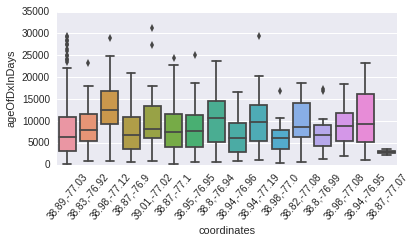

In [7]:
asthmaCodes = findICD_umls("asthma") # We go with ICD10 codes

## Get age of diagnosis & locations for FHIR synthetic patients.
p_agelocs = []

#print "Codes"
#print len(asthmaCodes)
#print asthmaCodes
p = []

for icd in asthmaCodes:
    try:
        pp = findPatients_fhir(icd)
        #print pp
        if len(pp)>0:
            #print "HERE"
            p = pp
        # patients with icd exist
    except:
        print "no patients with icd"
        exit()

#print "Patients"
#pprint.pprint(p)

p_ageloc = findDxAgeLocation_fhir(p)
#pprint.pprint(p_ageloc)
    
for dx in p_ageloc:
    num = int(dx[0])
    ageOfDxInDays = int(dx[1])
    dateAtDx = str(dx[2])
    lat = dx[3]
    lon = dx[4]
    coordinates=''+str(lat)+','+str(lon)+''
    #print coordinates
    p_agelocs.append((num, ageOfDxInDays,dateAtDx,lat,lon,coordinates))
    #p_agelocs.append(dx)
#print p_agelocs[1]
p_agelocs_df = pd.DataFrame(p_agelocs, columns=['id', 'ageOfDxInDays', 'dateAtDx', 'lat', 'lon','coordinates'])
#print  p_agelocs_df
    
s = p_agelocs_df['ageOfDxInDays']
print s.describe()
    
g = sns.factorplot(x="coordinates", y="ageOfDxInDays", data=p_agelocs_df, kind="box", size=3, aspect=2)
g.set_xticklabels(rotation=50)

##pprint.pprint(p_agelocs) # age at dx and coordinates
##pprint.pprint(p_agelocs_df) # age at dx and coordinates

### "What is the age range of Asthma diagnoses, grouped by air quality value?"

Note that we use PM2.5 values from  Open AQ Platform in order to identify air quality values from the greater Washington DC area.

The limitations we encountered are that either: (a) no information is returned, or (b) air quality of the greater Washington DC area for the last couple of weeks is returned.

We plot these data, but ultimately we would want more complete data and air quality values near the time of diagnosis.

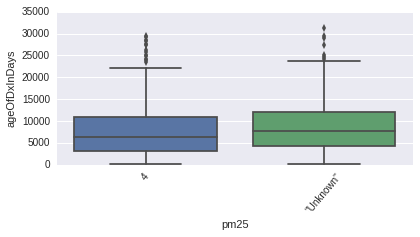

In [15]:
##For date of diagnosis and location, what is air quality (pm25)?

p_agelocspm25 = []

#print "##### CSV CUT HERE #####"
for item, p in p_agelocs_df.iterrows():
    #print "item, p"
    
    #print item
    #print p
    dateDx = p['dateAtDx']
    lat = p['lat']
    lon = p['lon']
    #print dateDx
    #print lat
    try:
        p_exp = findAirQualityAtDateOfDx(dateDx,lat,lon)
        #pprint.pprint(txt)
        #findExposureAtDateOfDx(dateDx,lon,lat)
    except:
        print "location not found"
        exit()
    n = p_exp['meta']['found'];
    #print p_exp['meta']
    #print p_exp
    if n > 0:
        pm25 = p_exp['results'][0]['value']
    else:
        pm25 = "\"Unknown\""
    # ****** UNCOMMENT THIS LINE TO GENERATE CSV ENTITIES ******
    # You will need to comment this line and rerun this sectioh to save changes.  Otherwise, you will
    # get an 'entity too large' error
    ##print str(p['id'])+","+str(p['ageOfDxInDays'])+",\""+str(p['dateAtDx'])+"\","+str(p['lat'])+","+str(p['lon'])+","+str(pm25)+""
    p_agelocspm25.append((p['id'], p['ageOfDxInDays'],p['dateAtDx'],p['coordinates'],pm25))
    
    #print pm25
#print "##### CSV CUT HERE #####"

#print p_agelocspm25
p_agelocspm25_df = pd.DataFrame(p_agelocspm25, columns=['id', 'ageOfDxInDays', 'dateAtDx', 'coordinates','pm25'])

g = sns.factorplot(x="pm25", y="ageOfDxInDays", data=p_agelocspm25_df, kind="box", size=3, aspect=2)
g.set_xticklabels(rotation=50)

